In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime

In [2]:
def missing_value_summary(df,df_title="",tpose = True,figsize=[15,6]):
    '''
    tpose - True if the figure should be transposed
    '''
    num_of_na = df.isna().sum(axis=0) #Dict with number of missing features by column
    print("Missing values in {}\n".format(df_title))
    [print(x,":",num_of_na[x]) 
     if num_of_na[x] != 0 
     else None 
     for x in df.columns] # Broken into multiple lines for better readability

    print("\nratio of missing features in the whole table: ", df.isna().sum().sum()/df.count().sum() )
    print("Number of rows: ", df.shape[0])

In [3]:
Parse = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date()
cars = pd.read_csv("cars.csv",encoding='latin', date_parser=Parse, parse_dates = ["dateCrawled", "dateCreated", "lastSeen"])
#getting rid of unnecessary data about the time of crawling
# enconding, otherwise UnicodeDecodeError
#https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python
print(cars.shape)
cars.head()

(371528, 20)


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24,0,70435,2016-04-07
1,2016-03-24,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24,0,66954,2016-04-07
2,2016-03-14,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14,0,90480,2016-04-05
3,2016-03-17,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17,0,91074,2016-03-17
4,2016-03-31,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31,0,60437,2016-04-06


In [4]:
cars_default = cars


In [5]:
cars = cars_default

# Exploratory data analysis

In [6]:
cars.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000,371528.0,371528.00000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445,0.0,50820.66764
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412,0.0,25799.08247
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.00000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000,0.0,30459.00000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.00000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000,0.0,71546.00000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.00000


In [7]:
cars.price.skew()

578.0590836551854

There's a lot to unpack here, so let's take a look at every column:
- Regarding the price distribution, we can see, that the mean is much greater than any quartiles values. Based on that I claim, that the distribution is not that skewed by itself, so to have such a great mean, it must be because of some outliers.
- The year of registration column has some weird element(min and the max), but other than that, it looks okayish. The mean is okay, though the standard deviation doesn't make too much sense.
- Power has the same problems: some outliers.
- The odometer data is actually believable.
- The month of registration is a little off, because there is 0-12 months (=13).
- The number of pictures is a column with full of zeros. Better be removed, no predictive power at all.
-  According to [Wiki on German postal codes](https://en.wikipedia.org/wiki/List_of_postal_codes_in_Germany), those should be between 0-99999. Postal codes look okay. There could be some digging made, if some postal codes exist at all, but it's not worth the effort at the moment.

In [8]:
cars.price.value_counts()

0         10778
500        5670
1500       5394
1000       4649
1200       4594
          ...  
23456         1
171000        1
21830         1
13485         1
8188          1
Name: price, Length: 5597, dtype: int64

In [9]:
cars = cars[cars.price > 0]  #lets remove every entry with 0 price
cars = cars[cars.price < 40000] 
#40000 euros @330 HUF/EUR is about 13M Ft. Set it as maximum, that the average driver would spend on a used car.

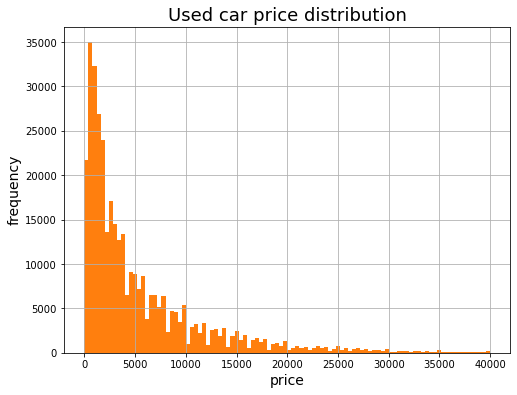

In [10]:
plt.figure(figsize=[8,6])
plt.hist(cars.price,bins=100, color="tab:orange")
plt.xlabel("price",size=14)
plt.title("Used car price distribution",size=18)
plt.ylabel("frequency",size=14)
plt.grid()
None

In [11]:
cars.yearOfRegistration.value_counts()
#We don't want our model to predict prices of exceptionally old cars, so let's limit the year of registration at 1980. Also, Limit the max year at 2016, since that was the year when the data was scraped, thus filter the outliers and false data.

2000    23109
1999    22023
2005    21685
2006    19944
2001    19724
        ...  
1925        1
3200        1
7800        1
1400        1
4100        1
Name: yearOfRegistration, Length: 143, dtype: int64

In [12]:
cars = cars[cars.yearOfRegistration > 1980]
cars = cars[cars.yearOfRegistration < 2017]

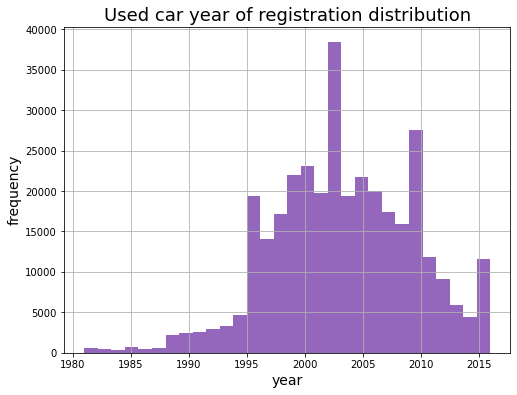

In [13]:
plt.figure(figsize=[8,6])
plt.hist(cars.yearOfRegistration,bins=30, color="tab:purple")
plt.xlabel("year",size=14)
plt.title("Used car year of registration distribution",size=18)
plt.ylabel("frequency",size=14)
plt.grid()
None

In [14]:
(cars.powerPS == 0).sum()
#This may indicate that the power data is missing here.
#Let's make a feature to express if the power data is missing, and the column with median

32047

In [15]:
cars["powerMissing"] = cars.powerPS.map(lambda x: 1 if x == 0 else 0)

In [16]:
power_median = cars.powerPS.median()
cars["powerPS"] = cars.powerPS.map(lambda x: power_median if x == 0 else x)

In [17]:
#Also remove industrial vehicles and racecars
cars = cars[cars.powerPS < 1000]

In [18]:
cars.monthOfRegistration.value_counts()
#I actually don't know what we could do about it. There is no pattern to recognize how we got 13 months, but this feature seems valuable. 
#We could introduce some periodicity, so that january and december are not so far away from each other.

3     33737
6     30732
0     28819
4     28738
5     28521
7     26572
10    25690
11    23990
12    23729
9     23565
1     22643
8     22153
2     20807
Name: monthOfRegistration, dtype: int64

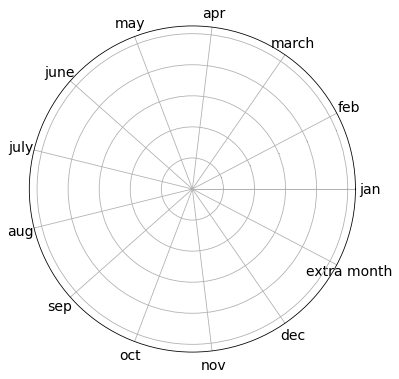

In [19]:
plt.figure(figsize=[8,6])
plt.polar()
plt.xticks(np.linspace(0,2*np.pi,14), ["jan","feb","march","apr","may","june","july","aug","sep","oct","nov","dec","extra month",""], size=14)
plt.yticks(size=0)
plt.savefig("polar_month_plot.png")

In [20]:
cars["monthOfReg1"] = np.cos((cars.monthOfRegistration) / 14 * 2*np.pi)
cars["monthOfReg2"] = np.sin((cars.monthOfRegistration) / 14 * 2*np.pi)


In [21]:
cars = cars.drop(columns= ["monthOfRegistration","nrOfPictures"])

In [22]:
cars.seller.value_counts()
#There's just 2 ads from a car dealership, let's get rid of this feature.

privat        339694
gewerblich         2
Name: seller, dtype: int64

In [23]:
cars = cars[cars.seller == "privat"].drop(columns="seller")

In [24]:
cars.offerType.value_counts()
#Again, there's only 1 buyer ad, the rest is all seller ads

Angebot    339689
Gesuch          5
Name: offerType, dtype: int64

In [25]:
cars = cars[cars.offerType == "Angebot"].drop(columns = "offerType")

In [26]:
cars.head()

,dateCrawled,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen,powerMissing,monthOfReg1,monthOfReg2
0,2016-03-24,Golf_3_1.6,480,test,NaN,1993,manuell,109.0,golf,150000,benzin,volkswagen,NaN,2016-03-24,70435,2016-04-07,1,1.000000,0.000000e+00
1,2016-03-24,A5_Sportback_2.7_Tdi,18300,test,coupe,2011,manuell,190.0,NaN,125000,diesel,audi,ja,2016-03-24,66954,2016-04-07,0,-0.623490,7.818315e-01
2,2016-03-14,"Jeep_Grand_Cherokee_""Overland""",9800,test,suv,2004,automatik,163.0,grand,125000,diesel,jeep,NaN,2016-03-14,90480,2016-04-05,0,-0.900969,-4.338837e-01
3,2016-03-17,GOLF_4_1_4__3TÜRER,1500,test,kleinwagen,2001,manuell,75.0,golf,150000,benzin,volkswagen,nein,2016-03-17,91074,2016-03-17,0,-0.900969,4.338837e-01
4,2016-03-31,Skoda_Fabia_1.4_TDI_PD_Classic,3600,test,kleinwagen,2008,manuell,69.0,fabia,90000,diesel,skoda,nein,2016-03-31,60437,2016-04-06,0,-1.000000,1.224647e-16


# Handling missing values

In [27]:
missing_value_summary(cars)

Missing values in 

vehicleType : 19566
gearbox : 15011
model : 15105
fuelType : 23597
notRepairedDamage : 59282

ratio of missing features in the whole table:  0.020969765230885562
Number of rows:  339689


In [28]:
cars["notRepairedDamage"].map(lambda x: 1 if pd.isnull(x) else 0)

0         1
1         0
2         1
3         0
4         0
         ..
371523    1
371524    0
371525    0
371526    1
371527    0
Name: notRepairedDamage, Length: 339689, dtype: int64

In [29]:
#Suppose that missing notRepairedDamage means that the car wasn't damaged at all.
cars["neverDamaged"] = cars.notRepairedDamage.map(lambda x: 1 if pd.isnull(x) else 0)
cars["notRepairedDamage"] = cars.notRepairedDamage.fillna("nein")

In [30]:
missing_value_summary(cars)

Missing values in 

vehicleType : 19566
gearbox : 15011
model : 15105
fuelType : 23597

ratio of missing features in the whole table:  0.010903800177992683
Number of rows:  339689


In [31]:
# Let's see if we can get some additional information if we have missing key info (model)

unique_models = cars.model.unique()
unique_models = np.delete(unique_models,1)

missing_model = cars[cars["model"].isna()] #cars with missing model

names = missing_model.name.str.lower().str.split("_")

new_model_name = pd.Series([ set(x).intersection(unique_models).pop() if not set(x).isdisjoint(unique_models) else np.nan for x in names],
                             index = missing_model.index)
#with this step we've gained 8600 more model names 

In [32]:
cars.loc[missing_model.index, "model"] = new_model_name

In [33]:
missing_value_summary(cars)

Missing values in 

vehicleType : 19566
gearbox : 15011
model : 7846
fuelType : 23597

ratio of missing features in the whole table:  0.009813072999036826
Number of rows:  339689


In [34]:
cars = cars.drop(index = cars[cars.model.isna()].index)

In [35]:
missing_value_summary(cars)

Missing values in 

vehicleType : 17623
gearbox : 13507
fuelType : 21138

ratio of missing features in the whole table:  0.007937925387024739
Number of rows:  331843


In [36]:
unique_brands = cars.brand.unique()
brand_model_dict = {}
for b in unique_brands:
    brand_model_dict[b] = cars[ cars.brand == b].model.unique()

In [37]:
missing_vtype = cars[cars.vehicleType.isna()]
vtype_by_model = cars[cars.vehicleType.notna()].groupby(["model","vehicleType"])[["vehicleType"]].count()
vtype_by_model_dict = {}

for model in unique_models:
    vtype_by_model_dict[model] = vtype_by_model.loc[model].idxmax()[0]
cars.loc[missing_vtype.index, "vehicleType"] = missing_vtype.model.map(vtype_by_model_dict)
#What I did here is I chose all the rows without missing vtype. Then looked at every model's most frequent vType, and paired it with the model in a key-value fashion: (model: most frequent vehicleType with the given model)
#For every missing vType, I imputed the car model's associated vType.

In [38]:
model_vtype_dict = {}
no_missing_vtype_cars = cars[cars.vehicleType.notna()]
for m in unique_models:
    model_vtype_dict[m] = no_missing_vtype_cars[no_missing_vtype_cars.model == m].vehicleType.value_counts().index[0]


In [39]:
missing_value_summary(cars)

Missing values in 

gearbox : 13507
fuelType : 21138

ratio of missing features in the whole table:  0.005247481337702574
Number of rows:  331843


In [40]:
missing_fuel = cars[cars.fuelType.isna()]
fuel_by_model = cars[cars.fuelType.notna()].groupby(["model","fuelType"])[["fuelType"]].count()
fuel_by_model_dict = {}

for model in unique_models:
    fuel_by_model_dict [model] = fuel_by_model.loc[model].idxmax()[0]
cars.loc[missing_fuel.index, "fuelType"] = missing_fuel.model.map(fuel_by_model_dict)

In [41]:
missing_value_summary(cars)

Missing values in 

gearbox : 13507

ratio of missing features in the whole table:  0.0020392994303640465
Number of rows:  331843


In [42]:
missing_gearbox = cars[cars.gearbox.isna()]
gearbox_by_model = cars[cars.gearbox.notna()].groupby(["model","gearbox"])[["gearbox"]].count()
gearbox_by_model_dict = {}

for model in unique_models:
    gearbox_by_model_dict[model] = gearbox_by_model.loc[model].idxmax()[0]
cars.loc[missing_gearbox.index, "gearbox"] = missing_gearbox.model.map(vtype_by_model_dict)

In [43]:
missing_value_summary(cars)

Missing values in 


ratio of missing features in the whole table:  0.0
Number of rows:  331843


In [44]:
cars["minDaysOnline"] = (cars.lastSeen - cars.dateCreated).dt.days
cars = cars.drop(columns = ["dateCreated","dateCrawled","lastSeen", "name"])
cars.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,postalCode,powerMissing,monthOfReg1,monthOfReg2,neverDamaged,minDaysOnline
0,480,test,limousine,1993,manuell,109.0,golf,150000,benzin,volkswagen,nein,70435,1,1.000000,0.000000e+00,1,14
1,18300,test,coupe,2011,manuell,190.0,a5,125000,diesel,audi,ja,66954,0,-0.623490,7.818315e-01,0,14
2,9800,test,suv,2004,automatik,163.0,grand,125000,diesel,jeep,nein,90480,0,-0.900969,-4.338837e-01,1,22
3,1500,test,kleinwagen,2001,manuell,75.0,golf,150000,benzin,volkswagen,nein,91074,0,-0.900969,4.338837e-01,0,0
4,3600,test,kleinwagen,2008,manuell,69.0,fabia,90000,diesel,skoda,nein,60437,0,-1.000000,1.224647e-16,0,6


In [45]:
cars = cars[cars["minDaysOnline"]  > 5]
#If we want to have a good prediction on the minimum time it takes for a car to be sold, there has to be a lower bound. Let it be 5 days.

In [46]:
cars.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,postalCode,powerMissing,monthOfReg1,monthOfReg2,neverDamaged,minDaysOnline
0,480,test,limousine,1993,manuell,109.0,golf,150000,benzin,volkswagen,nein,70435,1,1.000000,0.000000e+00,1,14
1,18300,test,coupe,2011,manuell,190.0,a5,125000,diesel,audi,ja,66954,0,-0.623490,7.818315e-01,0,14
2,9800,test,suv,2004,automatik,163.0,grand,125000,diesel,jeep,nein,90480,0,-0.900969,-4.338837e-01,1,22
4,3600,test,kleinwagen,2008,manuell,69.0,fabia,90000,diesel,skoda,nein,60437,0,-1.000000,1.224647e-16,0,6
9,999,test,kleinwagen,1998,manuell,101.0,golf,150000,benzin,volkswagen,nein,27472,0,1.000000,0.000000e+00,1,14


In [47]:
categorical = ["abtest", "vehicleType", "gearbox", "model","fuelType","brand","notRepairedDamage"]
y = cars.minDaysOnline
x_categorical = cars[categorical]
x_numerical = cars.drop(columns = categorical) 
x_numerical = x_numerical.drop(columns = "minDaysOnline")

In [48]:
from sklearn.preprocessing import MinMaxScaler
x_dummies = pd.get_dummies(x_categorical)
mmscaler = MinMaxScaler()
x_numerical = pd.DataFrame(mmscaler.fit_transform(x_numerical), columns = x_numerical.columns, index = x_numerical.index)

In [49]:
x = x_numerical.join(x_dummies)

In [50]:
szum = 0
for col in x_categorical.columns:
    q = len(x_categorical[col].unique())
    szum += q
szum

316

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Model

In [52]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import time
time1 = time.time()
reg = RandomForestRegressor(n_jobs = -1)
reg.fit(x_train,y_train)
print(time()- time1)

KeyboardInterrupt: 

In [ ]:
abs(reg.predict(x_test) - y_test).describe()

In [ ]:
!pip install --upgrade xgboost --user

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
reg2 = xgb.XGBRegressor() 
parameters = {'n_estimators': [60, 100, 120, 140], 
              'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'reg_lambda': [0.5]}

xgb_reg = GridSearchCV(estimator=reg2, param_grid=parameters, cv=5, n_jobs=-1).fit(x_train, y_train)